In [1]:
# Cài đặt các thư viện cần thiết
!pip install -q sacrebleu tokenizers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.6 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler, autocast
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
import sacrebleu
import time
import math
import os
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

In [3]:
# Cố định seed cho tất cả yếu tố ngẫu nhiên
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Thiết lập thiết bị 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# 1. Tiền xử lý dữ liệu
def load_parallel_data(vi_path, lo_path):
    with open(vi_path, 'r', encoding='utf-8') as vi_file, open(lo_path, 'r', encoding='utf-8') as lo_file:
        vi_sentences = [line.strip() for line in vi_file]
        lo_sentences = [line.strip() for line in lo_file]
    return list(zip(vi_sentences, lo_sentences))

# Đọc dữ liệu Train và Dev
train_data = load_parallel_data(
    "/kaggle/input/vlsp2023/VLSP2023/Train/train2023.vi",
    "/kaggle/input/vlsp2023/VLSP2023/Train/train2023.lo"
)
dev_data = load_parallel_data(
    "/kaggle/input/vlsp2023/VLSP2023/Dev/dev2023.vi",
    "/kaggle/input/vlsp2023/VLSP2023/Dev/dev2023.lo"
)

In [5]:
# print("First 10 pairs in train_data:")
# for i in range(20):
#     print(f"Vi: {train_data[i][0]}")
#     print(f"Lo: {train_data[i][1]}")

In [6]:
# 2. Huấn luyện hai tokenizer riêng biệt
def train_bpe_tokenizer(sentences, vocab_size=20000, file_prefix=""):
    if os.path.exists(f"{file_prefix}corpus.txt"):
        os.remove(f"{file_prefix}corpus.txt")
    if os.path.exists(f"{file_prefix}bpe_tokenizer.json"):
        os.remove(f"{file_prefix}bpe_tokenizer.json")

    tokenizer = Tokenizer(BPE())
    tokenizer.pre_tokenizer = Whitespace()
    trainer = BpeTrainer(vocab_size=vocab_size, special_tokens=["<pad>", "<sos>", "<eos>", "<unk>"])
    with open(f"{file_prefix}corpus.txt", "w", encoding="utf-8") as f:
        for sentence in sentences:
            f.write(f"{sentence}\n")
    tokenizer.train([f"{file_prefix}corpus.txt"], trainer)
    tokenizer.save(f"{file_prefix}bpe_tokenizer.json")
    print(f"{file_prefix}Tokenizer vocab size:", tokenizer.get_vocab_size())
    print(f"{file_prefix}First 10 tokens:", list(tokenizer.get_vocab().keys())[:10])
    return tokenizer

# Lấy câu tiếng Việt và tiếng Lào từ train_data
vi_sentences = [pair[0] for pair in train_data]
lo_sentences = [pair[1] for pair in train_data]

tokenizer_vi = train_bpe_tokenizer(vi_sentences, file_prefix="vi_")
tokenizer_lo = train_bpe_tokenizer(lo_sentences, file_prefix="lo_")




vi_Tokenizer vocab size: 20000
vi_First 10 tokens: ['ÀNG', 'QUẢN', 'DUS', 'UI', 'Bit', '410A', 'Tent', 'trix', '‛', 'Lạm']



lo_Tokenizer vocab size: 20000
lo_First 10 tokens: ['P', 'ຄອບຄົວ', 'IVE', '§', 'ພະຄໍາພີ', 'ພຽງພໍ', 'ການປິ່ນປົວດ້ວຍ', 'poly', 'Moz', 'ວ່າດ້ວຍ']


In [7]:
# 3. Dataset và Dataloader
class TranslationDataset(Dataset):
    def __init__(self, data, tokenizer_src, tokenizer_tgt, max_len=128, direction="vi2lo"):
        self.data = data
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.max_len = max_len
        self.direction = direction

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.direction == "vi2lo":
            src_text, tgt_text = self.data[idx]
            src_tokens = self.tokenizer_src.encode(src_text).ids  # Tiếng Việt
            tgt_tokens = self.tokenizer_tgt.encode(tgt_text).ids  # Tiếng Lào
        else:  # direction == "lo2vi"
            tgt_text, src_text = self.data[idx]
            src_tokens = self.tokenizer_src.encode(src_text).ids  # Tiếng Lào
            tgt_tokens = self.tokenizer_tgt.encode(tgt_text).ids  # Tiếng Việt
        
        # Thêm <sos> và <eos>
        src_tokens = [self.tokenizer_src.token_to_id("<sos>")] + src_tokens[:self.max_len-2] + [self.tokenizer_src.token_to_id("<eos>")]
        tgt_tokens = [self.tokenizer_tgt.token_to_id("<sos>")] + tgt_tokens[:self.max_len-2] + [self.tokenizer_tgt.token_to_id("<eos>")]
        
        # Padding
        src_tokens += [self.tokenizer_src.token_to_id("<pad>")] * (self.max_len - len(src_tokens))
        tgt_tokens += [self.tokenizer_tgt.token_to_id("<pad>")] * (self.max_len - len(tgt_tokens))
        
        return torch.tensor(src_tokens), torch.tensor(tgt_tokens)

# Tạo dataloader
batch_size = 32
train_dataset_vi2lo = TranslationDataset(train_data, tokenizer_vi, tokenizer_lo, direction="vi2lo")
dev_dataset_vi2lo = TranslationDataset(dev_data, tokenizer_vi, tokenizer_lo, direction="vi2lo")
train_loader_vi2lo = DataLoader(train_dataset_vi2lo, batch_size=batch_size, shuffle=True)
dev_loader_vi2lo = DataLoader(dev_dataset_vi2lo, batch_size=batch_size)

train_dataset_lo2vi = TranslationDataset(train_data, tokenizer_lo, tokenizer_vi, direction="lo2vi")
dev_dataset_lo2vi = TranslationDataset(dev_data, tokenizer_lo, tokenizer_vi, direction="lo2vi")
train_loader_lo2vi = DataLoader(train_dataset_lo2vi, batch_size=batch_size, shuffle=True)
dev_loader_lo2vi = DataLoader(dev_dataset_lo2vi, batch_size=batch_size)

In [8]:
# 4. Hàm tạo mask
def create_src_mask(src, pad_idx):
    mask = (src != pad_idx).unsqueeze(1).unsqueeze(2)
    return mask

def create_tgt_mask(tgt, pad_idx):
    seq_len = tgt.size(1)
    pad_mask = (tgt != pad_idx).unsqueeze(1).unsqueeze(2)
    nopeak_mask = torch.tril(torch.ones(seq_len, seq_len, device=tgt.device)).bool()
    nopeak_mask = nopeak_mask.unsqueeze(0)
    mask = pad_mask & nopeak_mask
    return mask

In [9]:
# 5. Rotary Positional Encoding (RoPE)
class RotaryPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.d_model = d_model
        theta = 10000.0 ** (-2.0 * torch.arange(0, d_model//2, dtype=torch.float) / d_model)
        self.register_buffer("theta", theta)
        
    def forward(self, x, positions=None):
        batch_size, seq_len, _ = x.size()
        if positions is None:
            positions = torch.arange(seq_len, device=x.device).unsqueeze(-1)
        
        angles = positions * self.theta
        sin_angles = torch.sin(angles)
        cos_angles = torch.cos(angles)
        
        x1, x2 = x[..., :self.d_model//2], x[..., self.d_model//2:]
        x_rot = torch.cat([
            x1 * cos_angles - x2 * sin_angles,
            x1 * sin_angles + x2 * cos_angles
        ], dim=-1)
        return x + x_rot

In [10]:
# 6. Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        
        q = self.q_linear(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = self.k_linear(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.v_linear(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e4)
        attn = torch.softmax(scores, dim=-1)
        context = torch.matmul(attn, v)
        
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.out_linear(context)
        return output

In [11]:
# 7. Feed-Forward Neural Network
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [12]:
# 8. Encoder Layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [13]:
# 9. Decoder Layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [14]:
# 10. Transformer Model
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_len=128, dropout=0.1):
        super().__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = RotaryPositionalEncoding(d_model, max_len)
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

In [15]:
# 11. Batch Beam Search
def batch_beam_search(model, src, tokenizer_src, tokenizer_tgt, beam_size=3, max_len=128):
    model.eval()
    batch_size = src.size(0)
    src = src.to(device)
    src_mask = create_src_mask(src, tokenizer_src.token_to_id("<pad>"))
    
    memory = model.encoder_embedding(src)
    memory = model.positional_encoding(memory)
    for enc_layer in model.encoder_layers:
        memory = enc_layer(memory, src_mask)
    
    ys = torch.full((batch_size, 1), tokenizer_tgt.token_to_id("<sos>"), dtype=torch.long, device=device)
    scores = torch.zeros(batch_size, device=device)
    beams = [(ys, scores)]
    
    for step in range(max_len):
        new_beams = []
        for ys, scores in beams:
            tgt_mask = create_tgt_mask(ys, tokenizer_tgt.token_to_id("<pad>"))
            with torch.no_grad():
                out = model.decoder_embedding(ys)
                out = model.positional_encoding(out)
                for dec_layer in model.decoder_layers:
                    out = dec_layer(out, memory, src_mask, tgt_mask)
                out = model.fc(out)
                probs = torch.softmax(out[:, -1, :], dim=-1)
                top_probs, top_idx = probs.topk(beam_size, dim=-1)
                for k in range(beam_size):
                    new_ys = torch.cat([ys, top_idx[:, k].unsqueeze(1)], dim=1)
                    new_scores = scores + torch.log(top_probs[:, k])
                    new_beams.append((new_ys, new_scores))
        beams = sorted(new_beams, key=lambda x: x[1].sum(), reverse=True)[:beam_size]
        last_tokens = beams[0][0][:, -1]
        if (last_tokens == tokenizer_tgt.token_to_id("<eos>")).all():
            break
    return beams[0][0]

In [16]:
# 12. Huấn luyện mô hình
def train_model(model, train_loader, val_loader, tokenizer_src, tokenizer_tgt, epochs=5, direction="vi2lo"):
    optimizer = optim.AdamW(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer_tgt.token_to_id("<pad>"))
    scaler = GradScaler('cuda')
    
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    best_model_path = f"best_model_{direction}.pt"
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        start_time = time.time()
        
        for src, tgt in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True):
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            
            src_mask = create_src_mask(src, tokenizer_src.token_to_id("<pad>"))
            tgt_mask = create_tgt_mask(tgt[:, :-1], tokenizer_tgt.token_to_id("<pad>"))
            
            with autocast('cuda'):
                output = model(src, tgt[:, :-1], src_mask, tgt_mask)
                loss = criterion(output.view(-1, output.size(-1)), tgt[:, 1:].contiguous().view(-1))
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}, Avg Train Loss: {avg_train_loss:.4f}, Time: {time.time()-start_time:.2f}s")
        
        val_loss = evaluate_model(model, val_loader, tokenizer_src, tokenizer_tgt, direction, criterion, "Dev")
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}, Avg Validation Loss: {val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")
    
    model.load_state_dict(torch.load(best_model_path))
    print(f"Loaded best model with validation loss: {best_val_loss:.4f}")
    
    plot_losses(train_losses, val_losses, direction)

In [17]:
# 13. Đánh giá mô hình
def evaluate_model(model, test_loader, tokenizer_src, tokenizer_tgt, direction="vi2lo", criterion=None, test_set_name="Test"):
    model.eval()
    predictions, references = [], []
    total_val_loss = 0
    total_tokens = 0
    start_time = time.time()
    
    with torch.no_grad():
        for src, tgt in tqdm(test_loader, desc=f"Evaluating on {test_set_name}", leave=True):
            src, tgt = src.to(device), tgt.to(device)
            
            if criterion is not None:
                src_mask = create_src_mask(src, tokenizer_src.token_to_id("<pad>"))
                tgt_mask = create_tgt_mask(tgt[:, :-1], tokenizer_tgt.token_to_id("<pad>"))
                with autocast('cuda'):
                    output = model(src, tgt[:, :-1], src_mask, tgt_mask)
                    loss = criterion(output.view(-1, output.size(-1)), tgt[:, 1:].contiguous().view(-1))
                total_val_loss += loss.item()
            else:
                pred_tokens = batch_beam_search(model, src, tokenizer_src, tokenizer_tgt)
                for i in range(pred_tokens.size(0)):
                    pred_text = tokenizer_tgt.decode(pred_tokens[i].cpu().numpy(), skip_special_tokens=True)
                    ref_text = tokenizer_tgt.decode(tgt[i].cpu().numpy(), skip_special_tokens=True)
                    predictions.append(pred_text)
                    references.append([ref_text])
                    total_tokens += len(pred_tokens[i])
    
    if criterion is not None:
        avg_val_loss = total_val_loss / len(test_loader)
        return avg_val_loss
    
    bleu = sacrebleu.corpus_bleu(predictions, references)
    inference_time = time.time() - start_time
    tokens_per_second = total_tokens / inference_time
    print(f"{test_set_name} - BLEU Score: {bleu.score:.2f}, Inference Time: {inference_time:.2f}s, Tokens/s: {tokens_per_second:.2f}")

In [18]:
# 14. Hàm vẽ biểu đồ loss
def plot_losses(train_losses, val_losses, direction):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
    plt.title(f'Training and Validation Loss ({direction.upper()})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.savefig(f'loss_plot_{direction}.png')

Training Vietnamese to Lao...


Epoch 1/5: 100%|██████████| 3125/3125 [04:34<00:00, 11.37it/s]


Epoch 1, Avg Train Loss: 6.5437, Time: 274.89s


Evaluating on Dev: 100%|██████████| 63/63 [00:01<00:00, 31.96it/s]


Epoch 1, Avg Validation Loss: 6.5948
Saved best model with validation loss: 6.5948


Epoch 2/5: 100%|██████████| 3125/3125 [04:37<00:00, 11.27it/s]


Epoch 2, Avg Train Loss: 5.5856, Time: 277.18s


Evaluating on Dev: 100%|██████████| 63/63 [00:01<00:00, 31.83it/s]


Epoch 2, Avg Validation Loss: 6.0002
Saved best model with validation loss: 6.0002


Epoch 3/5: 100%|██████████| 3125/3125 [04:36<00:00, 11.30it/s]


Epoch 3, Avg Train Loss: 5.1063, Time: 276.59s


Evaluating on Dev: 100%|██████████| 63/63 [00:01<00:00, 31.76it/s]


Epoch 3, Avg Validation Loss: 5.6000
Saved best model with validation loss: 5.6000


Epoch 4/5: 100%|██████████| 3125/3125 [04:36<00:00, 11.29it/s]


Epoch 4, Avg Train Loss: 4.7571, Time: 276.71s


Evaluating on Dev: 100%|██████████| 63/63 [00:01<00:00, 32.35it/s]


Epoch 4, Avg Validation Loss: 5.2837
Saved best model with validation loss: 5.2837


Epoch 5/5: 100%|██████████| 3125/3125 [04:36<00:00, 11.32it/s]


Epoch 5, Avg Train Loss: 4.4697, Time: 276.14s


Evaluating on Dev: 100%|██████████| 63/63 [00:01<00:00, 32.09it/s]


Epoch 5, Avg Validation Loss: 5.0266
Saved best model with validation loss: 5.0266
Loaded best model with validation loss: 5.0266
Training Lao to Vietnamese...


Epoch 1/5: 100%|██████████| 3125/3125 [04:36<00:00, 11.30it/s]


Epoch 1, Avg Train Loss: 5.9495, Time: 276.54s


Evaluating on Dev: 100%|██████████| 63/63 [00:01<00:00, 31.94it/s]


Epoch 1, Avg Validation Loss: 5.4941
Saved best model with validation loss: 5.4941


Epoch 2/5: 100%|██████████| 3125/3125 [04:36<00:00, 11.29it/s]


Epoch 2, Avg Train Loss: 4.8744, Time: 276.73s


Evaluating on Dev: 100%|██████████| 63/63 [00:01<00:00, 32.16it/s]


Epoch 2, Avg Validation Loss: 4.9633
Saved best model with validation loss: 4.9633


Epoch 3/5: 100%|██████████| 3125/3125 [04:36<00:00, 11.30it/s]


Epoch 3, Avg Train Loss: 4.4653, Time: 276.60s


Evaluating on Dev: 100%|██████████| 63/63 [00:01<00:00, 32.30it/s]


Epoch 3, Avg Validation Loss: 4.6399
Saved best model with validation loss: 4.6399


Epoch 4/5: 100%|██████████| 3125/3125 [04:36<00:00, 11.30it/s]


Epoch 4, Avg Train Loss: 4.1892, Time: 276.49s


Evaluating on Dev: 100%|██████████| 63/63 [00:01<00:00, 31.93it/s]


Epoch 4, Avg Validation Loss: 4.4099
Saved best model with validation loss: 4.4099


Epoch 5/5: 100%|██████████| 3125/3125 [04:36<00:00, 11.32it/s]


Epoch 5, Avg Train Loss: 3.9741, Time: 276.01s


Evaluating on Dev: 100%|██████████| 63/63 [00:01<00:00, 32.22it/s]


Epoch 5, Avg Validation Loss: 4.2296
Saved best model with validation loss: 4.2296
Loaded best model with validation loss: 4.2296


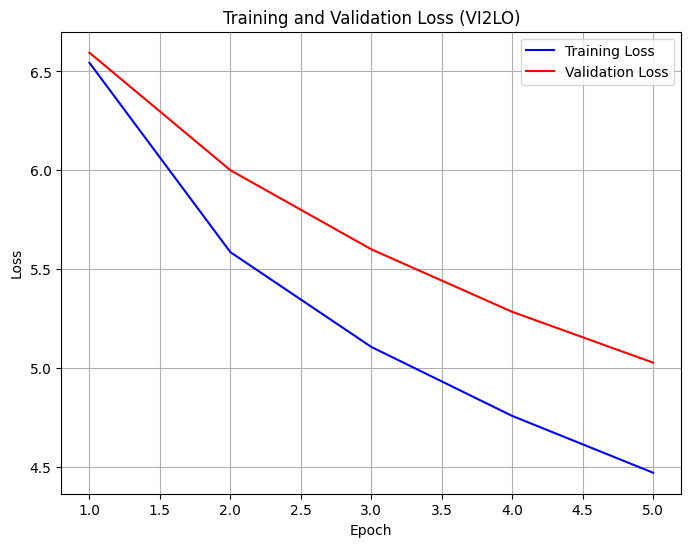

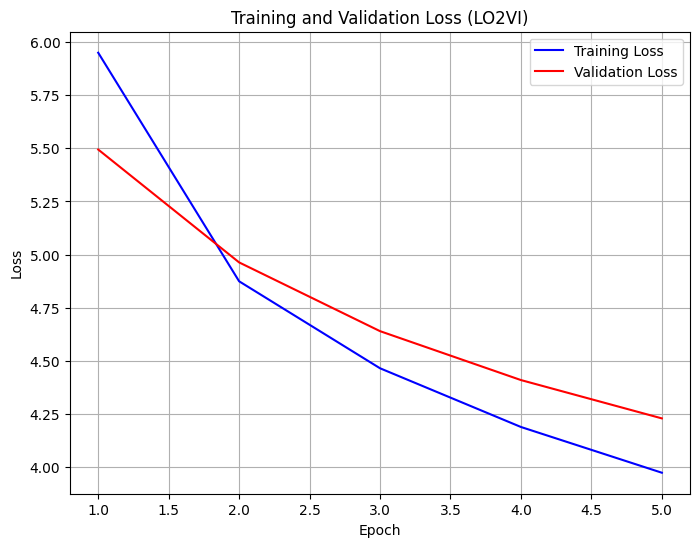

In [19]:
# 15. Khởi tạo và huấn luyện mô hình
d_model = 256
num_heads = 4
num_layers = 6
d_ff = 512
max_len = 128
dropout = 0.1

# Mô hình cho Việt-Lào
model_vi_to_lo = Transformer(tokenizer_vi.get_vocab_size(), tokenizer_lo.get_vocab_size(), d_model, num_heads, num_layers, d_ff, max_len, dropout).to(device)
print("Training Vietnamese to Lao...")
train_model(model_vi_to_lo, train_loader_vi2lo, dev_loader_vi2lo, tokenizer_vi, tokenizer_lo, epochs=5, direction="vi2lo")

# Mô hình cho Lào-Việt
model_lo_to_vi = Transformer(tokenizer_lo.get_vocab_size(), tokenizer_vi.get_vocab_size(), d_model, num_heads, num_layers, d_ff, max_len, dropout).to(device)
print("Training Lao to Vietnamese...")
train_model(model_lo_to_vi, train_loader_lo2vi, dev_loader_lo2vi, tokenizer_lo, tokenizer_vi, epochs=5, direction="lo2vi")

In [20]:
# 16. Đánh giá trên các tập test
# Tập Test công khai
test_data_public = load_parallel_data(
    "/kaggle/input/vlsp2023/VLSP2023/Test/public test/test_vi.txt",
    "/kaggle/input/vlsp2023/VLSP2023/Test/public test/test_lo.txt"
)

# Tập Test private Vi-Lo
test_data_private_vilo = load_parallel_data(
    "/kaggle/input/vlsp2023/VLSP2023/Test/private test/vi-lo/test2023.vi",
    "/kaggle/input/vlsp2023/VLSP2023/Test/private test/vi-lo/test2023.lo"
)

# Tập Test private Lo-Vi
test_data_private_lovi = load_parallel_data(
    "/kaggle/input/vlsp2023/VLSP2023/Test/private test/lo-vi/test2023.lo",
    "/kaggle/input/vlsp2023/VLSP2023/Test/private test/lo-vi/test2023.vi"
)

# Đánh giá Việt-Lào
test_dataset_vi2lo_public = TranslationDataset(test_data_public, tokenizer_vi, tokenizer_lo, direction="vi2lo")
test_loader_vi2lo_public = DataLoader(test_dataset_vi2lo_public, batch_size=batch_size)
print("Evaluating Vietnamese to Lao on Public Test Set...")
evaluate_model(model_vi_to_lo, test_loader_vi2lo_public, tokenizer_vi, tokenizer_lo, direction="vi2lo", test_set_name="Public Test Vi-Lo")

test_dataset_vi2lo_private = TranslationDataset(test_data_private_vilo, tokenizer_vi, tokenizer_lo, direction="vi2lo")
test_loader_vi2lo_private = DataLoader(test_dataset_vi2lo_private, batch_size=batch_size)
print("Evaluating Vietnamese to Lao on Private Test Set (Vi-Lo)...")
evaluate_model(model_vi_to_lo, test_loader_vi2lo_private, tokenizer_vi, tokenizer_lo, direction="vi2lo", test_set_name="Private Test Vi-Lo")

# Đánh giá Lào-Việt
test_dataset_lo2vi_public = TranslationDataset(test_data_public, tokenizer_lo, tokenizer_vi, direction="lo2vi")
test_loader_lo2vi_public = DataLoader(test_dataset_lo2vi_public, batch_size=batch_size)
print("Evaluating Lao to Vietnamese on Public Test Set...")
evaluate_model(model_lo_to_vi, test_loader_lo2vi_public, tokenizer_lo, tokenizer_vi, direction="lo2vi", test_set_name="Public Test Lo-Vi")

test_dataset_lo2vi_private = TranslationDataset(test_data_private_lovi, tokenizer_lo, tokenizer_vi, direction="lo2vi")
test_loader_lo2vi_private = DataLoader(test_dataset_lo2vi_private, batch_size=batch_size)
print("Evaluating Lao to Vietnamese on Private Test Set (Lo-Vi)...")
evaluate_model(model_lo_to_vi, test_loader_lo2vi_private, tokenizer_lo, tokenizer_vi, direction="lo2vi", test_set_name="Private Test Lo-Vi")

Evaluating Vietnamese to Lao on Public Test Set...


Evaluating on Public Test Vi-Lo: 100%|██████████| 32/32 [03:56<00:00,  7.39s/it]


Public Test Vi-Lo - BLEU Score: 24.81, Inference Time: 236.69s, Tokens/s: 500.02
Evaluating Vietnamese to Lao on Private Test Set (Vi-Lo)...


Evaluating on Private Test Vi-Lo: 100%|██████████| 32/32 [03:57<00:00,  7.41s/it]


Private Test Vi-Lo - BLEU Score: 24.81, Inference Time: 237.28s, Tokens/s: 498.79
Evaluating Lao to Vietnamese on Public Test Set...


Evaluating on Public Test Lo-Vi: 100%|██████████| 32/32 [04:35<00:00,  8.62s/it]


Public Test Lo-Vi - BLEU Score: 18.58, Inference Time: 275.89s, Tokens/s: 467.59
Evaluating Lao to Vietnamese on Private Test Set (Lo-Vi)...


Evaluating on Private Test Lo-Vi: 100%|██████████| 32/32 [04:36<00:00,  8.64s/it]


Private Test Lo-Vi - BLEU Score: 0.00, Inference Time: 276.66s, Tokens/s: 466.28


In [21]:
# print("First 10 pairs in test_data_private_lovi:")
# for i in range(10):
#     print(f"Lo: {test_data_private_lovi[i][0]}")
#     print(f"Vi: {test_data_private_lovi[i][1]}")